In [1]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Get dataset
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path=Path("data")
image_path = data_path / "pizza_steak_sushi"

# if the image folder dosent exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists. skipping download")
else:
  print(f"Downloading")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading pizza, steak, sushi data")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data")
  zip_ref.extractall(image_path)

Downloading
downloading pizza, steak, sushi data
Unzipping pizza, steak, sushi data


In [3]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir path, returning its contents
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [4]:
# Set up train and testing path

train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
from torchvision import transforms, datasets

In [6]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [7]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform, # a transform for the data
                                  target_transform=None) # a transform for the label

test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform,
                                 target_transform=None)

# 2. Turn the datasets into dataloaders

import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_simple = DataLoader(batch_size=BATCH_SIZE,
                                     dataset=train_data_simple,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(batch_size=BATCH_SIZE,
                                    dataset=test_data_simple,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [8]:
# Create TinyVGG model class

class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """

  def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, # we dk
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)

    x = self.conv_block_2(x)

    x = self.classifier(x)
    return x

In [9]:
class_names = train_data_simple.classes

In [10]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # num colour channels
                  hidden_units=10,
                  output_shape=len(class_names))

In [11]:
# try a forward pass on a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [12]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [13]:
# Create train and test loop functions

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()

  train_loss, train_acc = 0, 0

  # Loop thru data loader batches
  for batch, (X, y) in enumerate(dataloader):

    X, y = X.to(device), y.to(device)
    # 1. Forward Pass
    y_pred = model(X) # logits
    # 2. Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # adjust metrics
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc

In [14]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # Send data to device
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)

  return test_loss, test_acc


In [15]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
def train(num_epochs,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device=device):
  start_time = timer()
  results = {
        "train_loss": [],
        "test_loss": [],
        "train_acc": [],
        "test_acc": []
    }
  for epoch in tqdm(range(num_epochs)):

    print(f"Epoch: {epoch}\n---------")

    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    print(f"Train Loss: {train_loss} | Train Acc: {train_acc} | Test Loss {test_loss} | Test Acc {test_acc}")

  end_time = timer()
  print(f"Time taken for model to train and test: {end_time-start_time}")
  results["time"] = end_time - start_time

  return results

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20
model_0 = TinyVGG(input_shape=3,
                  output_shape=len((train_data_simple.classes)),
                  hidden_units=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_results = train(num_epochs=NUM_EPOCHS,
                        model=model_0.to(device),
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device)

model_0_results

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 1.106319084763527 | Train Acc: 0.3046875 | Test Loss 1.0983205238978069 | Test Acc 0.30113636363636365
Epoch: 1
---------
Train Loss: 1.0998057276010513 | Train Acc: 0.328125 | Test Loss 1.069690187772115 | Test Acc 0.5416666666666666
Epoch: 2
---------
Train Loss: 1.0868544578552246 | Train Acc: 0.48828125 | Test Loss 1.0807572205861409 | Test Acc 0.49242424242424243
Epoch: 3
---------
Train Loss: 1.0842333137989044 | Train Acc: 0.3984375 | Test Loss 1.0608317852020264 | Test Acc 0.5833333333333334
Epoch: 4
---------
Train Loss: 1.0662163347005844 | Train Acc: 0.4140625 | Test Loss 1.065395991007487 | Test Acc 0.5643939393939394
Epoch: 5
---------
Train Loss: 1.0305050686001778 | Train Acc: 0.43359375 | Test Loss 1.0139290889104207 | Test Acc 0.5426136363636364
Epoch: 6
---------
Train Loss: 0.9854370653629303 | Train Acc: 0.421875 | Test Loss 0.9323037465413412 | Test Acc 0.59375
Epoch: 7
---------
Train Loss: 0.9662912264466286 | Train Acc: 0.578125 | 

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844,
  1.0305050686001778,
  0.9854370653629303,
  0.9662912264466286,
  0.9238169267773628,
  0.9969005659222603,
  0.8698794320225716,
  0.9240578711032867,
  0.7841039318591356,
  0.9045028984546661,
  0.789142481982708,
  0.7492810562252998,
  0.7733712382614613,
  0.7480174712836742,
  0.7749622315168381,
  0.7755447328090668],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487,
  1.0139290889104207,
  0.9323037465413412,
  0.9987385471661886,
  1.0669610500335693,
  1.0631382465362549,
  0.9760761062304179,
  0.9350786805152893,
  0.9990029533704122,
  1.0629258553187053,
  0.9935221870740255,
  0.9946770668029785,
  1.0262615879376729,
  1.0648913383483887,
  1.041775107383728,
  1.053577144940694],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.3984375,
  0.4140625,
  0.43359375,
  0.4

In [17]:
# Plot loss curve of model 0
import matplotlib.pyplot as plt
model_0_results.keys()
def plot_loss_curves(results):
  # Get the loss values of a results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1),
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

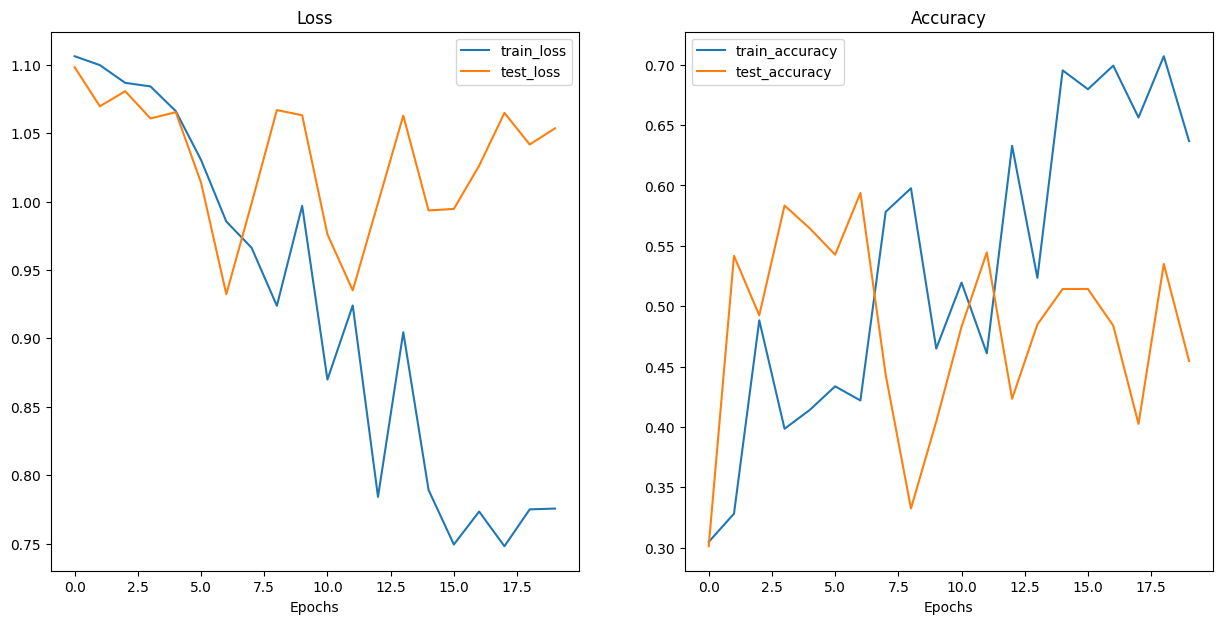

In [18]:
plot_loss_curves(model_0_results)

In [19]:
# Model 1: TinyVGG with data augmentation
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [20]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [21]:
train_data_augmented = ImageFolder(root='data/pizza_steak_sushi/train',
                            transform=train_transform_trivial,
                            target_transform=None
                          )

test_data_simple = ImageFolder(root='data/pizza_steak_sushi/test',
                           transform=test_transform_simple,
                           target_transform=None)

In [22]:
train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count()
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count()
)

In [23]:
print(f"Length of train_dataloader_augmented: {len(train_dataloader_augmented)}")
print(f"Length of test_dataloader_simple: {len(test_dataloader_simple)}")

Length of train_dataloader_augmented: 8
Length of test_dataloader_simple: 3


In [24]:
class_names = test_data_simple.classes

In [25]:
# Creatnig new model

torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))

In [26]:
# Training and testing model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

model_1_results = train(
    device=device,
    loss_fn=loss_fn,
    model=model_1.to(device),
    num_epochs=NUM_EPOCHS,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
)

print(f"Total training time: {model_1_results['time']}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 1.1035425812005997 | Train Acc: 0.25 | Test Loss 1.099348545074463 | Test Acc 0.2604166666666667
Epoch: 1
---------
Train Loss: 1.0761159732937813 | Train Acc: 0.42578125 | Test Loss 1.1299594640731812 | Test Acc 0.2604166666666667
Epoch: 2
---------
Train Loss: 1.0724116265773773 | Train Acc: 0.42578125 | Test Loss 1.1622153123219807 | Test Acc 0.2604166666666667
Epoch: 3
---------
Train Loss: 1.109900638461113 | Train Acc: 0.3046875 | Test Loss 1.1515795787175496 | Test Acc 0.2708333333333333
Epoch: 4
---------
Train Loss: 1.0834397971630096 | Train Acc: 0.35546875 | Test Loss 1.1495730479558308 | Test Acc 0.23958333333333334
Time taken for model to train and test: 13.283842319000001
Total training time: 13.283842319000001


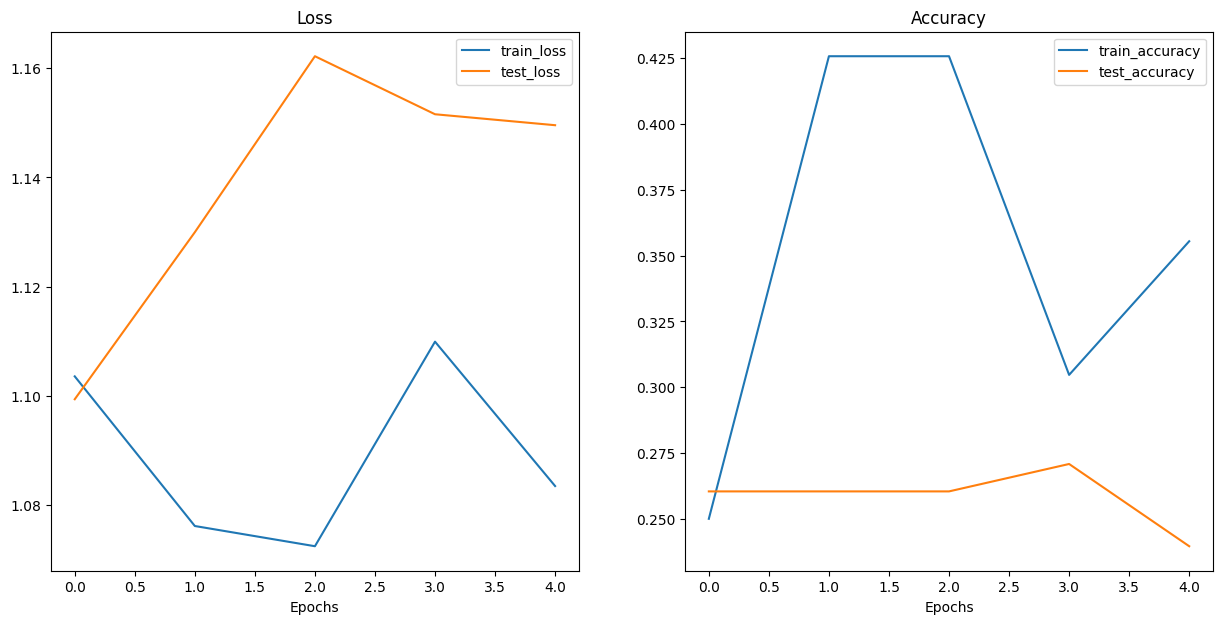

In [27]:
# Plot the loss curves.
# A loss curve helps you evaluate your model's performance over time.

plot_loss_curves(model_1_results)

In [30]:
# Compare model results to each other
import requests
from pathlib import Path
# Setup image path
custom_image_path = Path("data") / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print(f"Skipping download")

In [37]:
# We have to make sure our custom image is in the same format as the data our model was trained on.

import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
print(f"Custom Image Shape: {custom_image_uint8.shape} and datatype {custom_image_uint8.dtype}")


Custom Image Shape: torch.Size([3, 4032, 3024]) and datatype torch.float32


In [36]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [38]:
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

custom_image_transformed = custom_image_transform(custom_image_uint8.numpy())
print(f"Previous shape: {custom_image_uint8.shape} -> New shape: {custom_image_transformed.shape}")

TypeError: Unexpected type <class 'numpy.ndarray'>